In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)


PROJECT_ROOT: C:\Users\LAB1\Desktop\dev\personal_project\systematic-trading-framework


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from src.data.loaders import load_ohlcv
from src.data.validation import validate_ohlcv
from src.features import add_close_returns, add_volatility_features
from src.features.technical.trend import add_trend_features, add_trend_regime_features
from src.features.technical.momentum import add_momentum_features
from src.features.technical.oscillators import add_oscillator_features
from src.backtesting.engine import run_backtest
from src.backtesting.strategies import (
    buy_and_hold_signal,
    trend_state_signal,
    rsi_strategy,
    momentum_strategy,
    stochastic_strategy,
    volatility_regime_strategy,
)


In [ ]:
df = load_ohlcv("SPY", start="2015-01-01", interval="1d")
validate_ohlcv(df)

df = add_close_returns(df, log=True)
df = add_volatility_features(df, returns_col="close_logret")
df = add_trend_features(df, price_col="close", sma_windows=(20, 50), ema_spans=(20,))
df = add_trend_regime_features(df, price_col="close", base_sma_for_sign=50, short_sma=20, long_sma=50)
df = add_momentum_features(df, price_col="close", returns_col="close_logret")
df = add_oscillator_features(df, price_col="close", high_col="high", low_col="low")

df.tail()


Price,open,high,low,close,volume,close_logret,vol_rolling_10,vol_rolling_20,vol_rolling_60,vol_ewma_10,...,close_logret_norm_mom_5,close_mom_20,close_logret_mom_20,close_logret_norm_mom_20,close_mom_60,close_logret_mom_60,close_logret_norm_mom_60,close_rsi_14,close_stoch_k_14,close_stoch_d_14
Date,,,,,,,,,,,,,,,,,,,,,
2026-01-23,688.150024,690.960022,687.159973,689.229980,63059600,0.000363,0.136375,0.105486,0.116292,0.138333,...,-0.041311,0.001846,0.001844,0.017484,0.005823,0.005806,0.055039,52.790843,64.856355,57.889224
2026-01-26,690.489990,694.130005,689.919983,692.729980,60473800,0.005065,0.134499,0.106295,0.116623,0.128866,...,0.014543,0.003404,0.003398,0.031969,0.008253,0.008219,0.077320,56.120526,82.786665,70.406213
2026-01-27,694.179993,696.530029,693.570007,695.489990,55506100,0.003976,0.135917,0.107139,0.116887,0.117975,...,0.243506,0.007504,0.007476,0.069777,0.011784,0.011715,0.109342,58.600241,94.789389,80.810803
2026-01-28,697.049988,697.840027,693.940002,695.419983,61172200,-0.000101,0.135449,0.106148,0.114513,0.107323,...,0.136727,0.011005,0.010945,0.103112,0.022932,0.022673,0.213599,58.509921,88.622277,88.732777
2026-01-29,696.390015,697.059998,684.830017,694.039978,97338600,-0.001986,0.133093,0.106352,0.114452,0.099434,...,0.068803,0.010233,0.010181,0.095727,0.017564,0.017412,0.163720,56.656146,82.134249,88.515305


In [ ]:
MODES = ["long_only", "short_only", "long_short", "long_short_hold"]


In [ ]:
def run_mode_backtests(strategy_func, strategy_kwargs, base_name):
    results = []
    for mode in MODES:
        sig_col = f"{base_name}_{mode}"
        df[sig_col] = strategy_func(df, signal_name=sig_col, mode=mode, **strategy_kwargs)
        res = run_backtest(
            df,
            signal_col=sig_col,
            returns_col="close_logret",
            cost_per_unit_turnover=0.0005,
        )
        results.append({"mode": mode, **res.summary})
    return pd.DataFrame(results).set_index("mode")


In [ ]:
df["signal_buy_and_hold"] = buy_and_hold_signal(df)
res_bh = run_backtest(df, signal_col="signal_buy_and_hold", returns_col="close_logret", cost_per_unit_turnover=0.0005)
res_bh.summary


{'cumulative_return': 0.6474044553073972,
 'annualized_return': 0.0462057748834066,
 'annualized_vol': 0.15229804060583432,
 'sharpe': 0.3033904750159768,
 'max_drawdown': -0.3461077817544901}

In [ ]:
trend_results = run_mode_backtests(
    trend_state_signal,
    {"state_col": "close_trend_state_sma_20_50"},
    base_name="signal_trend_state",
)
trend_results


,cumulative_return,annualized_return,annualized_vol,sharpe,max_drawdown
mode,,,,,
long_only,0.708191,0.049642,0.104455,0.475242,-0.251635
short_only,-0.204796,-0.020522,0.069492,-0.295312,-0.292188
long_short,-0.074868,-0.007017,0.112961,-0.062116,-0.387613
long_short_hold,-0.074868,-0.007017,0.112961,-0.062116,-0.387613


In [ ]:
rsi_results = run_mode_backtests(
    rsi_strategy,
    {"rsi_col": "close_rsi_14", "buy_level": 30.0, "sell_level": 70.0},
    base_name="signal_rsi",
)
rsi_results


,cumulative_return,annualized_return,annualized_vol,sharpe,max_drawdown
mode,,,,,
long_only,0.582288,0.042395,0.064775,0.654499,-0.074807
short_only,-0.083164,-0.007826,0.024653,-0.317441,-0.099063
long_short,0.450698,0.034237,0.069326,0.493860,-0.092334
long_short_hold,0.450698,0.034237,0.069326,0.493860,-0.092334


In [ ]:
mom_results = run_mode_backtests(
    momentum_strategy,
    {"momentum_col": "close_logret_mom_20", "long_threshold": 0.0},
    base_name="signal_momentum",
)
mom_results


,cumulative_return,annualized_return,annualized_vol,sharpe,max_drawdown
mode,,,,,
long_only,0.976521,0.063591,0.104151,0.610565,-0.147062
short_only,-0.305609,-0.032463,0.071415,-0.454567,-0.321185
long_short,-0.285778,-0.029995,0.138001,-0.217352,-0.403222
long_short_hold,-0.285778,-0.029995,0.138001,-0.217352,-0.403222


In [ ]:
stoch_results = run_mode_backtests(
    stochastic_strategy,
    {"k_col": "close_stoch_k_14", "buy_level": 20.0, "sell_level": 80.0},
    base_name="signal_stoch",
)
stoch_results


,cumulative_return,annualized_return,annualized_vol,sharpe,max_drawdown
mode,,,,,
long_only,0.416262,0.031992,0.096527,0.331429,-0.189788
short_only,-0.180869,-0.017891,0.027120,-0.659694,-0.218576
long_short,-0.132368,-0.012766,0.057316,-0.222722,-0.222309
long_short_hold,-0.132368,-0.012766,0.057316,-0.222722,-0.222309


In [ ]:
vol_results = run_mode_backtests(
    volatility_regime_strategy,
    {"vol_col": "vol_rolling_20", "quantile": 0.5},
    base_name="signal_vol_regime",
)
vol_results


,cumulative_return,annualized_return,annualized_vol,sharpe,max_drawdown
mode,,,,,
long_only,0.480482,0.036141,0.075854,0.476457,-0.152808
short_only,-0.351135,-0.038381,0.082114,-0.467418,-0.358384
long_short,-0.232534,-0.023663,0.111838,-0.211586,-0.286140
long_short_hold,-0.232534,-0.023663,0.111838,-0.211586,-0.286140


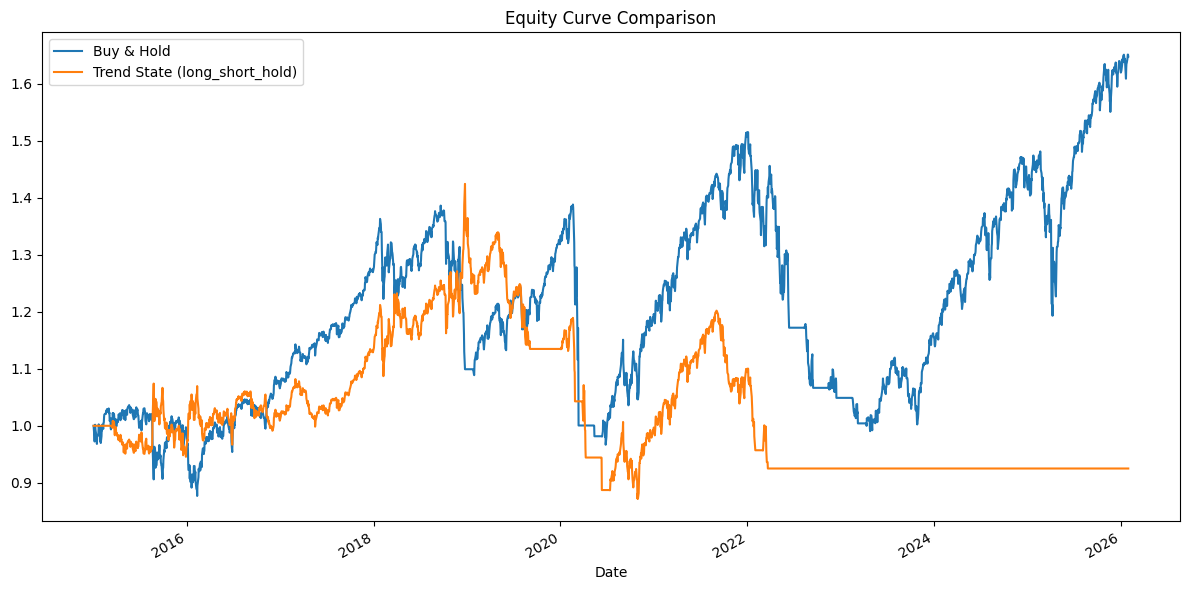

In [ ]:
df["signal_trend_ls"] = trend_state_signal(
    df, state_col="close_trend_state_sma_20_50", signal_name="signal_trend_ls", mode="long_short_hold"
)
res_trend = run_backtest(
    df,
    signal_col="signal_trend_ls",
    returns_col="close_logret",
    cost_per_unit_turnover=0.0005,
)

fig, ax = plt.subplots(figsize=(12, 6))
res_bh.equity_curve.plot(ax=ax, label="Buy & Hold")
res_trend.equity_curve.plot(ax=ax, label="Trend State (long_short_hold)")
ax.set_title("Equity Curve Comparison")
ax.legend()
plt.tight_layout()
